<a href="https://colab.research.google.com/github/AAdewunmi/Breast-Cancer-Risk-Prediction-Project/blob/main/Breast_Cancer_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Risk Prediction (Colab + Keras 3)

A compact, reproducible notebook workflow for **binary image classification** (Benign vs Malignant) using **DenseNet201** transfer learning in **TensorFlow / Keras 3**. The project includes clean data loading utilities, augmentation, modern training helpers (no deprecated APIs), notebook-friendly tests, and quick visual diagnostics.

---

## Features

* ✅ PNG loader that converts to RGB and resizes with OpenCV
* ✅ Deterministic shuffling, one-hot labels (0=Benign, 1=Malignant)
* ✅ Train/val split + grid preview utility
* ✅ Transfer head on **DenseNet201** with proper loss/metrics
* ✅ **ImageDataGenerator** augmentation and **ReduceLROnPlateau** callback
* ✅ Modern **`model.fit`** (no `fit_generator`), **Adam(learning_rate=...)**
* ✅ Colab-friendly **unittest** cells for smoke tests
* ✅ Plotting helpers and troubleshooting notes (inline backend, curve behavior)

---

## Project Structure (notebook-centric)

```
.
├── Breast_Cancer_Risk_Prediction.ipynb        # Main notebook (Colab-ready)
├── data/
│   ├── benign/                                # PNG images of benign cases
│   └── malign/                                # PNG images of malignant cases
└── README.md                                  # You are here
```

> If your data is on Google Drive, mount and point the loader to:
> `drive/MyDrive/Colab Notebooks/Breast-Cancer-Risk-Prediction/data/{benign,malign}`

---

## Environment

* Python 3.11+ (Colab default is fine)
* TensorFlow/Keras 3.x
* numpy, opencv-python, pillow, matplotlib, scikit-learn, tqdm, pandas

**Colab:** `Runtime → Change runtime type → Hardware accelerator: GPU`

Local (optional):

```bash
python -m venv .venv && source .venv/bin/activate
pip install --upgrade pip
pip install tensorflow numpy opencv-python pillow matplotlib scikit-learn tqdm pandas
```

---

## Data Loading

`Dataset_loader` loads **.png** files, converts to **RGB**, resizes to `(RESIZE, RESIZE)`:

```python
benign = Dataset_loader(".../data/benign", 224)   # -> np.ndarray (N_b, 224, 224, 3)
malign = Dataset_loader(".../data/malign", 224)   # -> np.ndarray (N_m, 224, 224, 3)
```

Labels and merge:

```python
benign_label = np.zeros(len(benign), dtype=np.int64)
malign_label = np.ones(len(malign), dtype=np.int64)

X = np.concatenate([benign, malign], axis=0)
Y = np.concatenate([benign_label, malign_label], axis=0)
Y = to_categorical(Y, num_classes=2)              # one-hot (N, 2)
```

Shuffle & split (with stratification):

```python
from sklearn.model_selection import train_test_split

y_int = np.argmax(Y, axis=1)
x_train, x_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=y_int
)
```

---

## Quick Visual Check

```python
fig, used = plot_image_grid(
    x_train, y_train, rows=3, columns=4, class_names=("Benign", "Malignant")
)
plt.show()
```

---

## Model

Backbone:

```python
backbone = build_backbone(
    name="DenseNet201",
    input_shape=(224, 224, 3),
    weights="imagenet",
    trainable=False,  # freeze for warm-up
)
```

Classifier:

```python
model = build_classifier(
    backbone,
    num_classes=2,   # softmax + categorical_crossentropy
    dropout=0.5,
    lr=1e-4          # Adam(learning_rate=...)
)
model.summary()
```

> With 2-class one-hot labels, use **`categorical_crossentropy`** (not binary CE).

**(Recommended)** DenseNet preprocessing:

```python
from tensorflow.keras.applications.densenet import preprocess_input

train_datagen = make_image_datagen(preprocessing_function=preprocess_input)
x_val_pp = preprocess_input(x_val.copy())
```

---

## Training

Modern Keras 3 wrapper (replaces `fit_generator`):

```python
BATCH_SIZE = 16
lr_cb = make_lr_scheduler(monitor="val_accuracy", patience=5, factor=0.2, min_lr=1e-7)

history = train_with_generator(
    model,
    x_train, y_train,
    x_val, y_val,  # or (x_val_pp, y_val) if using preprocess_input
    batch_size=BATCH_SIZE,
    epochs=7,
    datagen=make_image_datagen(
        rotation_range=90, zoom_range=2.0, horizontal_flip=True, vertical_flip=True
    ),
    callbacks=[lr_cb],
)
```

Why this wrapper?

* Uses `model.fit(...)` (correct for Keras 3)
* Avoids unsupported args (`workers`, `use_multiprocessing`)
* Uses ceil(`N / batch_size`) for `steps_per_epoch`

---

## Metrics & Plots

```python
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Ensure inline backend (if tests set Agg previously)
try:
    plt.switch_backend("module://matplotlib_inline.backend_inline")
except Exception:
    pass

hist = pd.DataFrame(history.history)
ax = hist[["loss", "val_loss"]].plot(title="Loss"); ax.grid(True); plt.show()
ax = hist[["accuracy", "val_accuracy"]].plot(title="Accuracy"); ax.grid(True); plt.show()
```

> If curves don’t intersect, that’s common with strong augmentation, few epochs, or missing model-specific preprocessing.

---

## Notebook Tests (Colab-friendly)

* **Split & Grid Tests** – checks split sizes, grid titles for one-hot & int labels, custom indices, and error cases.
* **Training Helper Tests** – tiny CNN on synthetic data validates LR scheduler, generator training (couple epochs), and expected history keys.

Run each `unittest` cell; look for green `OK`.

---

## Troubleshooting

* **No plots** → ensure `%matplotlib inline` and switch back to inline if a prior cell used `Agg`.
* **Optimizer arg error** → use `Adam(learning_rate=...)` (Keras 3).
* **`fit_generator` missing** → deprecated; always use `model.fit`.
* **Metric names** → `val_accuracy` not `val_acc`.
* **Curves don’t cross** → reduce augmentation, add `preprocess_input`, train longer (15–30 epochs), or unfreeze top layers to provoke overfitting.

---

## Reproducibility

* Seed numpy/Keras generators (`seed=` in `flow`).
* Note your `tensorflow` / `keras` versions (Colab updates fast).

---

## Next Steps

* Class weights or focal loss for imbalance
* Fine-tuning: unfreeze top DenseNet blocks after warm-up
* Mixed precision training
* Confusion matrix, ROC-AUC, PR-AUC, calibration
* `ModelCheckpoint` to save best weights
* Promote helpers to a small module + pytest for local dev

---

## Acknowledgements

* Keras Applications (DenseNet201)
* Breast cancer imaging datasets (observe their licenses)


In [29]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Install core ML/CV dependencies

!pip install numpy pandas matplotlib tensorflow keras opencv-python Pillow scikit-learn scipy tqdm

In [31]:
# Installs all core libraries required for the model training script,
# including TensorFlow/Keras, NumPy, Pandas, scikit-learn, OpenCV (cv2),
# and Pillow.

import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow
from keras import layers
from tensorflow.keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


In [32]:
# Implement Dataset_loader and init benign/malign datasets

import os
from typing import Tuple, Union, List

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm


def Dataset_loader(DIR: str, RESIZE: Union[int, Tuple[int, int]], sigmaX: float = 0.0) -> np.ndarray:
    """
    Load all PNG images from a directory, convert them to RGB, resize, and return a NumPy array.

    Parameters
    ----------
    DIR : str
        Directory containing images. Only files with a .png extension (case-insensitive) are loaded.
    RESIZE : int | tuple[int, int]
        Target size. If an int, images are resized to (RESIZE, RESIZE).
        If a tuple, interpret as (width, height) per OpenCV's convention.
    sigmaX : float, optional
        Standard deviation for Gaussian blur. If > 0, apply cv2.GaussianBlur; default is 0 (no blur).

    Returns
    -------
    np.ndarray
        Array of shape (N, H, W, 3) in uint8 RGB, where N is the number of images.
        If the directory has no PNGs, returns an empty array with shape (0, H, W, 3).

    Raises
    ------
    FileNotFoundError
        If the provided directory does not exist.
    ValueError
        If RESIZE is a tuple with non-positive values.

    Notes
    -----
    - Uses PIL to read and ensure RGB; uses OpenCV for resizing (INTER_AREA).
    - Processing order is deterministic (alphabetical file name sort).
    - Consider renaming to `load_dataset` for PEP 8 compliance in future refactors.

    Examples
    --------
    >>> imgs = Dataset_loader("/path/to/benign", 224)
    >>> imgs.shape
    (N, 224, 224, 3)
    """
    if not os.path.isdir(DIR):
        raise FileNotFoundError(f"Directory not found: {DIR}")

    # Normalize RESIZE into an (width, height) tuple for OpenCV.
    if isinstance(RESIZE, int):
        target_size: Tuple[int, int] = (RESIZE, RESIZE)
    else:
        if len(RESIZE) != 2 or RESIZE[0] <= 0 or RESIZE[1] <= 0:
            raise ValueError("RESIZE tuple must be (width, height) with positive integers.")
        target_size = (int(RESIZE[0]), int(RESIZE[1]))

    # Collect .png files only (case-insensitive), sorted for reproducibility
    entries: List[str] = sorted(os.listdir(DIR))
    png_paths = [
        os.path.join(DIR, name)
        for name in entries
        if os.path.splitext(name)[1].lower() == ".png"
    ]

    # Early return with empty (0, H, W, 3) if no PNGs found
    if not png_paths:
        return np.empty((0, target_size[1], target_size[0], 3), dtype=np.uint8)

    images = []
    for path in tqdm(png_paths, desc=f"Loading {os.path.basename(DIR) or DIR}"):
        # Read with PIL, enforce RGB
        rgb = np.asarray(Image.open(path).convert("RGB"))
        # Resize with OpenCV (expects (width, height))
        resized = cv2.resize(rgb, target_size, interpolation=cv2.INTER_AREA)
        # Optional blur for preprocessing
        if sigmaX and sigmaX > 0:
            resized = cv2.GaussianBlur(resized, ksize=(0, 0), sigmaX=sigmaX)
        images.append(resized.astype(np.uint8))

    return np.stack(images, axis=0)

# pass RESIZE and fix the typo in the second path
benign = Dataset_loader(
    "drive/MyDrive/Colab Notebooks/Breast-Cancer-Risk-Prediction/data/benign",
    224
)
malign = Dataset_loader(
    "drive/MyDrive/Colab Notebooks/Breast-Cancer-Risk-Prediction/data/malign",
    224
)


Loading malign: 100%|██████████| 127/127 [00:08<00:00, 15.71it/s]


In [33]:
"""
Notebook-friendly unit tests for `Dataset_loader`.

Usage
-----
1) Define `Dataset_loader` in a previous cell (or ensure `src/dataloader.py` is importable).
2) Run this cell. You'll get a unittest report in the output.

Notes
-----
- Uses `unittest` (no external CLI needed).
- Creates temporary images and folders; cleans up after itself.
- Mirrors the original pytest assertions closely.
"""

import os
import sys
import unittest
import tempfile
from pathlib import Path

import numpy as np
from PIL import Image

# Optional: If you're in a fresh Colab and missing deps used by Dataset_loader,
# you may need to install them in a separate cell:
# !pip install pillow opencv-python tqdm

# Try to access Dataset_loader from the current notebook scope;
# if not present, attempt import from src.dataloader.
try:
    Dataset_loader  # type: ignore  # noqa: F401
except NameError:
    try:
        from src.dataloader import Dataset_loader  # type: ignore
    except Exception as e:
        raise RuntimeError(
            "Dataset_loader not found. Define it in a previous cell or ensure src/dataloader.py is importable."
        ) from e


def _make_img(path: Path, size=(30, 20), color=(120, 60, 30)):
    """
    Create a simple RGB image and save it to `path` (PNG or JPG based on extension).

    Parameters
    ----------
    path : Path
        Destination file path (extension determines format).
    size : tuple[int, int]
        (width, height) of the image to create.
    color : tuple[int, int, int]
        RGB color fill for the created image.
    """
    img = Image.new("RGB", size, color)
    img.save(path)


class DatasetLoaderNotebookTests(unittest.TestCase):
    """Unit tests for `Dataset_loader` adapted for a single Colab cell."""

    def setUp(self):
        # Fresh temp directory for each test
        self._tmpdir = tempfile.TemporaryDirectory()
        self.tmp = Path(self._tmpdir.name)

    def tearDown(self):
        # Cleanup temp directory
        self._tmpdir.cleanup()

    def test_load_pngs_and_resize(self):
        d = self.tmp / "images"
        d.mkdir(parents=True, exist_ok=True)

        # Two PNGs (including uppercase extension) and one JPG (ignored)
        _make_img(d / "a.png", size=(50, 40), color=(255, 0, 0))
        _make_img(d / "b.PNG", size=(40, 50), color=(0, 255, 0))  # case-insensitive
        _make_img(d / "c.jpg", size=(60, 60), color=(0, 0, 255))  # should be ignored

        arr = Dataset_loader(str(d), 224)
        self.assertIsInstance(arr, np.ndarray)
        self.assertEqual(arr.shape, (2, 224, 224, 3))
        self.assertEqual(arr.dtype, np.uint8)

    def test_resize_tuple_width_height(self):
        d = self.tmp / "imgs"
        d.mkdir(parents=True, exist_ok=True)

        _make_img(d / "x.png", size=(10, 10))
        _make_img(d / "y.png", size=(20, 5))

        # (width, height) per OpenCV convention
        arr = Dataset_loader(str(d), (120, 80))
        self.assertEqual(arr.shape, (2, 80, 120, 3))

    def test_nonexistent_dir_raises(self):
        with self.assertRaises(FileNotFoundError):
            Dataset_loader(str(self.tmp / "no_such_dir"), 224)

    def test_empty_dir_returns_empty_array(self):
        d = self.tmp / "empty"
        d.mkdir(parents=True, exist_ok=True)

        arr = Dataset_loader(str(d), 64)
        self.assertIsInstance(arr, np.ndarray)
        self.assertEqual(arr.shape, (0, 64, 64, 3))


# Run tests when the cell executes
unittest.main(argv=[""], verbosity=2, exit=False)

test_empty_dir_returns_empty_array (__main__.DatasetLoaderNotebookTests.test_empty_dir_returns_empty_array) ... ok
Loading images: 100%|██████████| 2/2 [00:00<00:00, 481.97it/s]
ok
test_nonexistent_dir_raises (__main__.DatasetLoaderNotebookTests.test_nonexistent_dir_raises) ... ok
Loading imgs: 100%|██████████| 2/2 [00:00<00:00, 749.45it/s]
ok
test_build_backbone_supported_and_trainable_flag (__main__.TestModelBuilders.test_build_backbone_supported_and_trainable_flag)
Backbone builds without top; respects `trainable` flag. ... ok
test_build_backbone_unsupported_raises (__main__.TestModelBuilders.test_build_backbone_unsupported_raises)
Unsupported backbone names raise ValueError. ... ok
test_classifier_binary_sigmoid_and_loss (__main__.TestModelBuilders.test_classifier_binary_sigmoid_and_loss)
Binary setup (num_classes=1) uses sigmoid + binary_crossentropy and (B,1) output. ... WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one

In [34]:
# Add class label arrays for benign/malign

benign_label = np.zeros(len(benign))
malign_label = np.ones(len(malign))

In [35]:
# Combine images and labels into X/Y

X = np.concatenate((benign,malign), axis=0)
Y = np.concatenate((benign_label, malign_label), axis=0)

In [36]:
# Shuffle dataset and one-hot encode labels

s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]
Y = to_categorical(Y, num_classes=2)

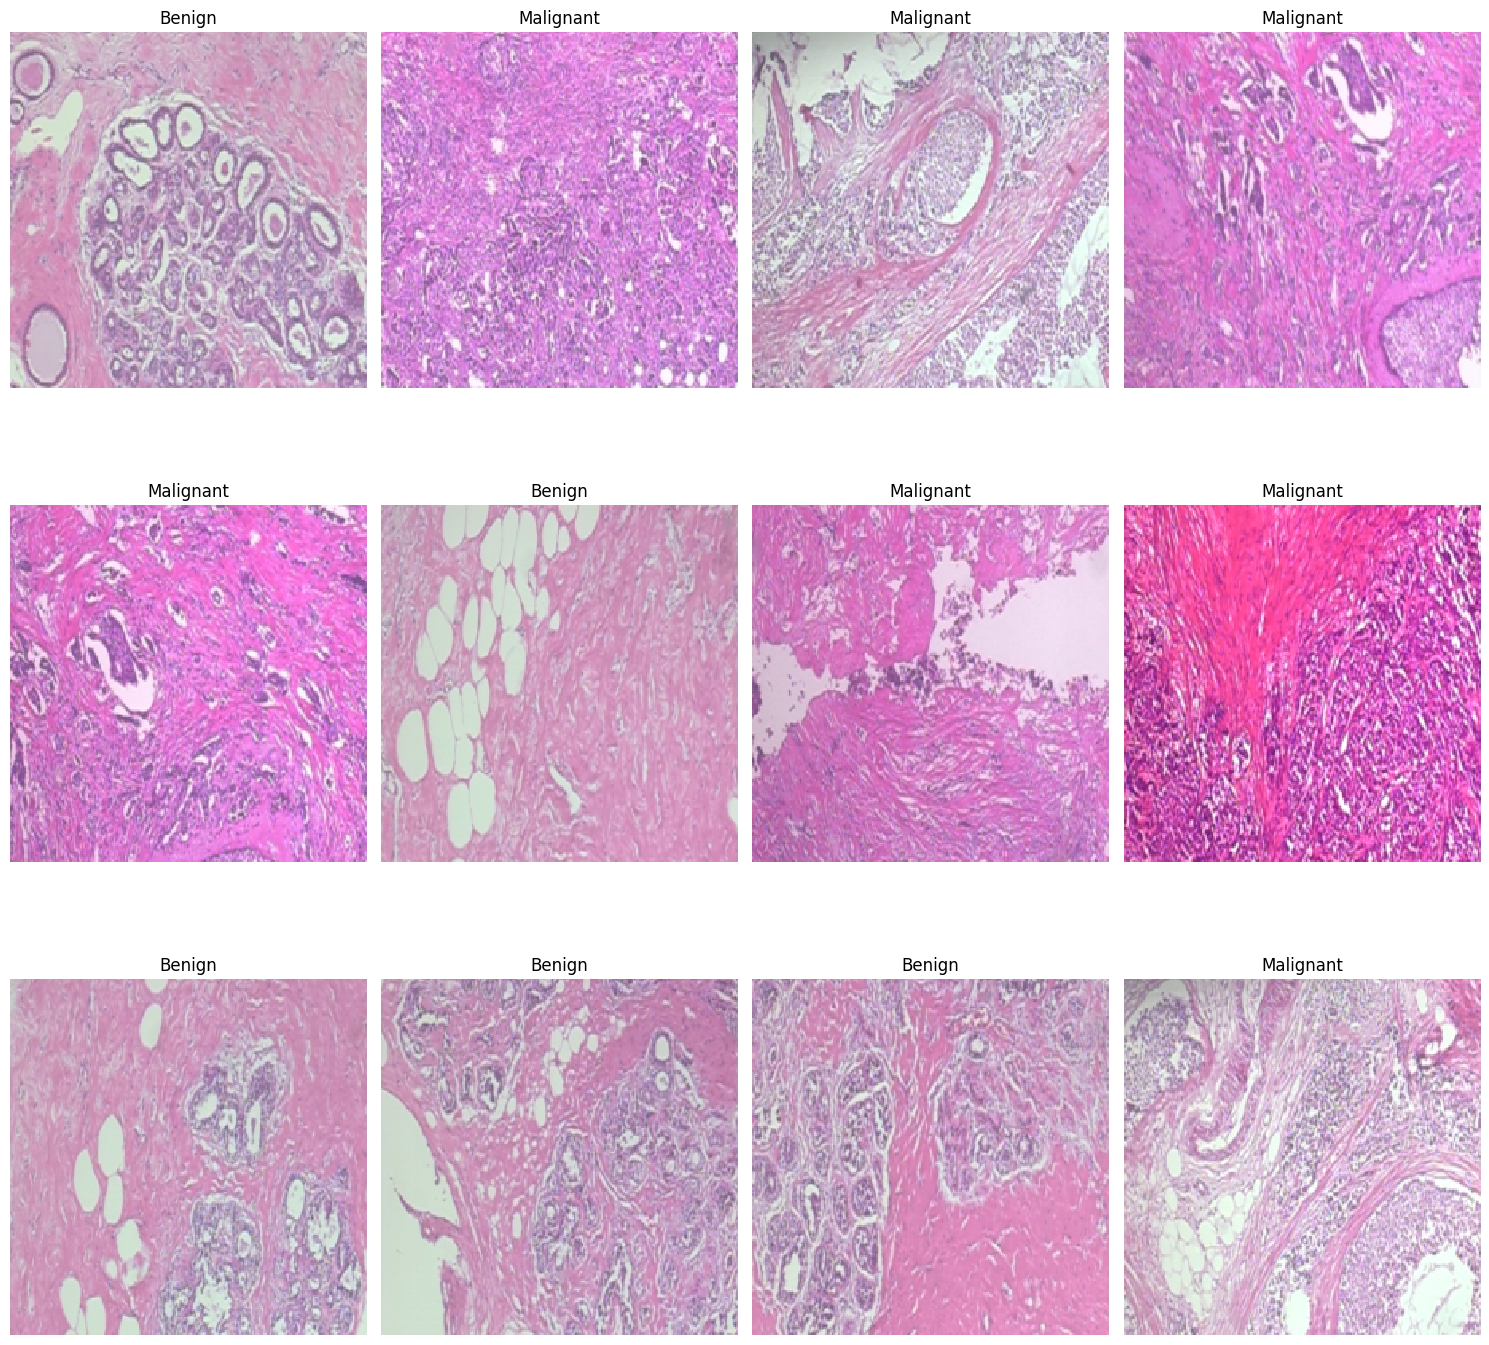

In [37]:
# Train/val split + grid preview

# Helpers + plotting

from __future__ import annotations
from typing import Iterable, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def split_dataset(
    X: np.ndarray,
    Y: np.ndarray,
    test_size: float = 0.20,
    random_state: int = 42,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split images and labels into train/validation sets.

    Parameters
    ----------
    X : np.ndarray
        Image array of shape (N, H, W, C).
    Y : np.ndarray
        Label array of shape (N,) for integer labels or (N, K) for one-hot labels.
    test_size : float, optional
        Fraction for validation split. Default is 0.20.
    random_state : int, optional
        Random seed for reproducibility. Default is 42.

    Returns
    -------
    x_train, x_val, y_train, y_val : tuple of np.ndarray
        Train/validation splits matching scikit-learn's `train_test_split` behavior.
    """
    return train_test_split(X, Y, test_size=test_size, random_state=random_state, shuffle=True)


def plot_image_grid(
    x: np.ndarray,
    y: np.ndarray,
    rows: int = 3,
    columns: int = 4,
    figsize: Tuple[int, int] = (15, 15),
    class_names: Optional[Sequence[str]] = ("Benign", "Malignant"),
    indices: Optional[Iterable[int]] = None,
    shuffle: bool = False,
    random_state: Optional[int] = None,
    interpolation: str = "nearest",
):
    """
    Plot a grid of sample images with titles derived from labels.

    Works with integer labels or one-hot labels.

    Parameters
    ----------
    x : np.ndarray
        Image array of shape (N, H, W, C) in RGB order.
    y : np.ndarray
        Labels as integers (N,) or one-hot encoded (N, K).
    rows : int, optional
        Number of rows in the grid. Default is 3.
    columns : int, optional
        Number of columns in the grid. Default is 4.
    figsize : (int, int), optional
        Matplotlib figure size. Default is (15, 15).
    class_names : sequence of str or None, optional
        Class names used for titles. If None, numeric labels are shown.
        Length should match number of classes when y is one-hot.
    indices : iterable of int or None, optional
        Exact sample indices to plot. If None, the function selects the first `rows*columns`
        after optional shuffling.
    shuffle : bool, optional
        If True and `indices` is None, randomly permute the dataset before selecting samples.
    random_state : int or None, optional
        Seed for shuffling when `shuffle=True`.
    interpolation : str, optional
        Matplotlib interpolation mode for imshow. Default is "nearest".

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created Matplotlib figure.
    used_indices : np.ndarray
        The indices of samples displayed (length == rows * columns).

    Raises
    ------
    ValueError
        If there are not enough samples to fill the grid or shapes are incompatible.

    Notes
    -----
    - If labels are one-hot (N, K), the function uses argmax along axis=1.
    - Axis ticks are hidden for a cleaner gallery view.
    """
    if x.ndim != 4 or x.shape[0] != y.shape[0]:
        raise ValueError(f"Incompatible shapes: x{tuple(x.shape)} y{tuple(y.shape)}")

    n = x.shape[0]
    k = rows * columns
    if k <= 0:
        raise ValueError("rows * columns must be positive.")

    # Normalize labels to integer class ids
    y_int = y
    if y.ndim == 2:
        y_int = np.argmax(y, axis=1)
    elif y.ndim != 1:
        raise ValueError("y must be shape (N,) for integer labels or (N, K) for one-hot.")

    # Determine which indices to plot
    if indices is not None:
        used_indices = np.array(list(indices), dtype=int)
    else:
        used_indices = np.arange(n)
        if shuffle:
            rng = np.random.default_rng(random_state)
            rng.shuffle(used_indices)
        used_indices = used_indices[:k]

    if used_indices.size < k:
        raise ValueError(f"Not enough samples to fill the grid: need {k}, have {used_indices.size}")

    # Build the figure
    fig = plt.figure(figsize=figsize)
    for j, idx in enumerate(used_indices[:k], start=1):
        ax = fig.add_subplot(rows, columns, j)
        ax.imshow(x[idx], interpolation=interpolation)
        ax.axis("off")

        label_id = int(y_int[idx])
        if class_names is not None and 0 <= label_id < len(class_names):
            ax.set_title(class_names[label_id])
        else:
            ax.set_title(str(label_id))

    plt.tight_layout()
    return fig, used_indices

x_train, x_val, y_train, y_val = split_dataset(X, Y, test_size=0.2, random_state=42)
fig, used = plot_image_grid(x_train, y_train, rows=3, columns=4, class_names=("Benign","Malignant"))
plt.show()


In [38]:
# Add Colab-friendly unittest for split/plot grid

import unittest
import numpy as np
import matplotlib
matplotlib.use("Agg")  # headless for tests
import matplotlib.pyplot as plt


class TestNotebookGrid(unittest.TestCase):
    def setUp(self):
        # Make a tiny synthetic dataset: 20 RGB images, labels 0/1
        self.N = 20
        self.H = 32
        self.W = 32
        self.C = 3
        rng = np.random.default_rng(0)
        self.X = rng.integers(0, 256, size=(self.N, self.H, self.W, self.C), dtype=np.uint8)
        self.y_int = rng.integers(0, 2, size=(self.N,), dtype=np.int64)
        # One-hot version
        self.y_oh = np.eye(2, dtype=np.float32)[self.y_int]

    def tearDown(self):
        plt.close("all")

    def test_split_shapes(self):
        x_tr, x_va, y_tr, y_va = split_dataset(self.X, self.y_oh, test_size=0.2, random_state=42)
        self.assertEqual(x_tr.shape[0], 16)
        self.assertEqual(x_va.shape[0], 4)
        # y carries same first dimension
        self.assertEqual(y_tr.shape[0], 16)
        self.assertEqual(y_va.shape[0], 4)

    def test_plot_with_one_hot(self):
        fig, used = plot_image_grid(
            self.X, self.y_oh,
            rows=3, columns=4,
            class_names=("Benign", "Malignant"),
            shuffle=False
        )
        # We expect exactly 12 indices
        self.assertEqual(len(used), 12)
        # Titles should match argmax labels
        axs = fig.get_axes()
        for ax, idx in zip(axs, used):
            expected = ("Benign", "Malignant")[int(np.argmax(self.y_oh[idx]))]
            self.assertEqual(ax.get_title(), expected)
        plt.close(fig)

    def test_plot_with_integer_labels(self):
        fig, used = plot_image_grid(
            self.X, self.y_int,
            rows=2, columns=3,
            class_names=("Benign", "Malignant"),
            shuffle=True,
            random_state=123
        )
        self.assertEqual(len(used), 6)
        axs = fig.get_axes()
        for ax, idx in zip(axs, used):
            expected = ("Benign", "Malignant")[int(self.y_int[idx])]
            self.assertEqual(ax.get_title(), expected)
        plt.close(fig)

    def test_custom_indices(self):
        custom = [0, 2, 4, 6]
        fig, used = plot_image_grid(
            self.X, self.y_int,
            rows=2, columns=2,
            class_names=("Benign", "Malignant"),
            indices=custom
        )
        self.assertTrue(np.array_equal(used, np.array(custom)))
        plt.close(fig)

    def test_insufficient_samples_raises(self):
        with self.assertRaises(ValueError):
            plot_image_grid(self.X, self.y_int, rows=5, columns=5)  # needs 25; we only have 20


unittest.main(argv=[""], verbosity=2, exit=False)


test_empty_dir_returns_empty_array (__main__.DatasetLoaderNotebookTests.test_empty_dir_returns_empty_array) ... ok
Loading images: 100%|██████████| 2/2 [00:00<00:00, 1236.71it/s]
ok
test_nonexistent_dir_raises (__main__.DatasetLoaderNotebookTests.test_nonexistent_dir_raises) ... ok
Loading imgs: 100%|██████████| 2/2 [00:00<00:00, 877.38it/s]
ok
test_build_backbone_supported_and_trainable_flag (__main__.TestModelBuilders.test_build_backbone_supported_and_trainable_flag)
Backbone builds without top; respects `trainable` flag. ... ok
test_build_backbone_unsupported_raises (__main__.TestModelBuilders.test_build_backbone_unsupported_raises)
Unsupported backbone names raise ValueError. ... ok
test_classifier_binary_sigmoid_and_loss (__main__.TestModelBuilders.test_classifier_binary_sigmoid_and_loss)
Binary setup (num_classes=1) uses sigmoid + binary_crossentropy and (B,1) output. ... ok
test_classifier_two_class_softmax_and_loss (__main__.TestModelBuilders.test_classifier_two_class_softmax_a

In [39]:
# Set BATCH_SIZE=16 and add Keras ImageDataGenerator

BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [40]:
# Add DenseNet201 transfer head + compile

# Model builders

from __future__ import annotations
from typing import Optional, Sequence, Tuple

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet201


def build_backbone(
    name: str = "DenseNet201",
    input_shape: Tuple[int, int, int] = (224, 224, 3),
    weights: Optional[str] = "imagenet",
    trainable: bool = False,
) -> tf.keras.Model:
    """
    Create a convolutional feature extractor (backbone) from `tf.keras.applications`
    with `include_top=False`, suitable for transfer learning.

    Parameters
    ----------
    name : str, optional
        Backbone name. Currently supports: "DenseNet201". Default is "DenseNet201".
    input_shape : tuple[int, int, int], optional
        Input tensor shape (H, W, C). Default is (224, 224, 3).
    weights : str or None, optional
        Pretrained weights: "imagenet" or None (random init). Default "imagenet".
    trainable : bool, optional
        Whether backbone layers are trainable. Default False (frozen).

    Returns
    -------
    tf.keras.Model
        A Keras model without classification head (include_top=False).

    Raises
    ------
    ValueError
        If the backbone `name` is not supported.
    """
    lname = name.lower()
    if lname == "densenet201":
        backbone = DenseNet201(include_top=False, weights=weights, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported backbone '{name}'. Supported: ['DenseNet201']")

    backbone.trainable = trainable
    return backbone


def build_classifier(
    backbone: tf.keras.Model,
    num_classes: int = 2,
    dropout: float = 0.5,
    lr: float = 1e-4,
    loss: Optional[str] = None,
    metrics: Optional[Sequence[str]] = None,
) -> tf.keras.Model:
    """
    Stack a light classification head on a convolutional backbone and compile.

    Head: GAP → (Dropout) → BatchNorm → Dense(units, activation)

    Parameters
    ----------
    backbone : tf.keras.Model
        Feature extractor with spatial outputs (e.g., DenseNet201 w/ include_top=False).
    num_classes : int, optional
        Number of classes. If 1 → sigmoid; if >1 → softmax. Default 2.
    dropout : float, optional
        Dropout rate after GAP. Set 0 to disable. Default 0.5.
    lr : float, optional
        Optimizer learning rate. Default 1e-4.
    loss : str or None, optional
        Loss to use. If None, chooses:
          - 'binary_crossentropy' when num_classes == 1
          - 'categorical_crossentropy' when num_classes > 1
    metrics : sequence[str] or None, optional
        Metrics list. Default ['accuracy'].

    Returns
    -------
    tf.keras.Model
        Compiled Keras model ready for `fit`.

    Notes
    -----
    - Uses `Adam(learning_rate=lr)` (new Keras API; `lr=` is invalid).
    - With one-hot labels and 2 classes, prefer `categorical_crossentropy`.
    """
    if metrics is None:
        metrics = ["accuracy"]

    if num_classes == 1:
        units, activation = 1, "sigmoid"
        loss = loss or "binary_crossentropy"
    else:
        units, activation = num_classes, "softmax"
        loss = loss or "categorical_crossentropy"

    model = models.Sequential(name=f"{backbone.name}_classifier")
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    if dropout and dropout > 0:
        model.add(layers.Dropout(dropout))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units, activation=activation))

    optimizer = optimizers.Adam(learning_rate=lr)  # <- fix: use learning_rate
    model.compile(optimizer=optimizer, loss=loss, metrics=list(metrics))
    return model

backbone = build_backbone("DenseNet201", input_shape=(224, 224, 3), weights="imagenet", trainable=False)
model = build_classifier(backbone, num_classes=2, lr=1e-4)
model.summary()


Model: "densenet201_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         3,842 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,333,506 (69.94 MB)

 Trainable params: 7,682 (30.01 KB)

 Non-trainable params: 18,325,824 (69.91 MB)

In [41]:
# Tests (unittest; avoids downloads by using weights=None)

import unittest
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models


class TestModelBuilders(unittest.TestCase):
    """Notebook-friendly tests for `build_backbone` and `build_classifier`."""

    def test_build_backbone_supported_and_trainable_flag(self):
        """Backbone builds without top; respects `trainable` flag."""
        bb = build_backbone("DenseNet201", input_shape=(64, 64, 3), weights=None, trainable=False)
        # Should output a 4D feature map (no top)
        self.assertEqual(len(bb.output_shape), 4)
        # Frozen as requested
        any_trainable = any(l.trainable for l in bb.layers)
        self.assertFalse(any_trainable)

    def test_build_backbone_unsupported_raises(self):
        """Unsupported backbone names raise ValueError."""
        with self.assertRaises(ValueError):
            build_backbone("UnknownNet", input_shape=(64, 64, 3), weights=None)

    def test_classifier_two_class_softmax_and_loss(self):
        """Two-class setup uses softmax + categorical_crossentropy and correct output shape."""
        bb = build_backbone("DenseNet201", input_shape=(64, 64, 3), weights=None)
        model = build_classifier(bb, num_classes=2, lr=1e-4)
        self.assertEqual(model.loss, "categorical_crossentropy")
        # Forward pass shape check
        x = np.random.randint(0, 256, size=(2, 64, 64, 3), dtype=np.uint8) / 255.0
        y = model.predict(x, verbose=0)
        self.assertEqual(y.shape, (2, 2))
        # Softmax rows should sum ~1
        row_sums = np.sum(y, axis=1)
        self.assertTrue(np.allclose(row_sums, 1.0, atol=1e-5))

    def test_classifier_binary_sigmoid_and_loss(self):
        """Binary setup (num_classes=1) uses sigmoid + binary_crossentropy and (B,1) output."""
        # Tiny dummy backbone to keep this test fast
        inp = layers.Input(shape=(32, 32, 3))
        z = layers.Conv2D(8, 3, padding="same", activation="relu")(inp)
        z = layers.MaxPooling2D()(z)
        dummy_bb = models.Model(inp, z, name="dummy_backbone")
        model = build_classifier(dummy_bb, num_classes=1, lr=1e-4)
        self.assertEqual(model.loss, "binary_crossentropy")
        x = np.random.rand(4, 32, 32, 3).astype("float32")
        y = model.predict(x, verbose=0)
        self.assertEqual(y.shape, (4, 1))
        # Outputs in (0,1)
        self.assertTrue(np.logical_and(y >= 0.0, y <= 1.0).all())


unittest.main(argv=[""], verbosity=2, exit=False)


test_empty_dir_returns_empty_array (__main__.DatasetLoaderNotebookTests.test_empty_dir_returns_empty_array) ... ok
Loading images: 100%|██████████| 2/2 [00:00<00:00, 1081.01it/s]
ok
test_nonexistent_dir_raises (__main__.DatasetLoaderNotebookTests.test_nonexistent_dir_raises) ... ok
Loading imgs: 100%|██████████| 2/2 [00:00<00:00, 1278.95it/s]
ok
test_build_backbone_supported_and_trainable_flag (__main__.TestModelBuilders.test_build_backbone_supported_and_trainable_flag)
Backbone builds without top; respects `trainable` flag. ... ok
test_build_backbone_unsupported_raises (__main__.TestModelBuilders.test_build_backbone_unsupported_raises)
Unsupported backbone names raise ValueError. ... ok
test_classifier_binary_sigmoid_and_loss (__main__.TestModelBuilders.test_classifier_binary_sigmoid_and_loss)
Binary setup (num_classes=1) uses sigmoid + binary_crossentropy and (B,1) output. ... ok
test_classifier_two_class_softmax_and_loss (__main__.TestModelBuilders.test_classifier_two_class_softmax_

In [42]:
# Use model.fit with generator + ReduceLROnPlateau

# Training helpers

# Cell 1 — Colab-ready training helpers (no deprecated args)

from __future__ import annotations
from typing import Optional, Sequence
import math

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model


def make_image_datagen(
    rotation_range: int = 90,
    zoom_range: float = 2.0,
    horizontal_flip: bool = True,
    vertical_flip: bool = True,
    **kwargs,
) -> ImageDataGenerator:
    """
    Create a Keras `ImageDataGenerator` for on-the-fly augmentation.

    Parameters
    ----------
    rotation_range : int
        Degree range for random rotations.
    zoom_range : float
        Range for random zoom (e.g., 2.0).
    horizontal_flip : bool
        Randomly flip inputs horizontally.
    vertical_flip : bool
        Randomly flip inputs vertically.
    kwargs : dict
        Extra args passed to `ImageDataGenerator` (e.g., rescale=1/255.).

    Returns
    -------
    ImageDataGenerator
        Configured image augmenter.
    """
    return ImageDataGenerator(
        rotation_range=rotation_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        **kwargs,
    )


def make_lr_scheduler(
    monitor: str = "val_accuracy",
    patience: int = 5,
    factor: float = 0.2,
    min_lr: float = 1e-7,
    verbose: int = 1,
) -> ReduceLROnPlateau:
    """
    Build a `ReduceLROnPlateau` callback using modern Keras metric names.

    Parameters
    ----------
    monitor : str
        Metric to monitor (e.g., 'val_accuracy').
    patience : int
        Epochs with no improvement before LR is reduced.
    factor : float
        LR multiplier on plateau (new_lr = lr * factor).
    min_lr : float
        Lower bound on LR.
    verbose : int
        Verbosity.

    Returns
    -------
    ReduceLROnPlateau
        Configured learning-rate scheduler.
    """
    return ReduceLROnPlateau(
        monitor=monitor, patience=patience, factor=factor, min_lr=min_lr, verbose=verbose
    )


def train_with_generator(
    model: Model,
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_val: Optional[np.ndarray] = None,
    y_val: Optional[np.ndarray] = None,
    batch_size: int = 16,
    epochs: int = 7,
    datagen: Optional[ImageDataGenerator] = None,
    callbacks: Optional[Sequence[tf.keras.callbacks.Callback]] = None,
    shuffle: bool = True,
    seed: Optional[int] = None,
    verbose: int = 1,
) -> tf.keras.callbacks.History:
    """
    Train a compiled Keras model using an ImageDataGenerator source via `model.fit`.

    This replaces deprecated `model.fit_generator(...)` and avoids unsupported
    arguments like `workers` / `use_multiprocessing` under Keras 3's TF trainer.

    Parameters
    ----------
    model : keras.Model
        Compiled Keras model.
    x_train : np.ndarray
        Training images of shape (N, H, W, C).
    y_train : np.ndarray
        Training labels, integer or one-hot.
    x_val : np.ndarray, optional
        Validation images (M, H, W, C).
    y_val : np.ndarray, optional
        Validation labels; required if `x_val` provided.
    batch_size : int
        Batch size for training.
    epochs : int
        Number of epochs.
    datagen : ImageDataGenerator, optional
        Augmenter. If None, a default similar to your config is used.
    callbacks : sequence of Callback, optional
        Keras callbacks (e.g., ReduceLROnPlateau).
    shuffle : bool
        Whether to shuffle samples within the generator.
    seed : int, optional
        Seed for generator RNG.
    verbose : int
        Keras fit verbosity (0, 1, or 2).

    Returns
    -------
    keras.callbacks.History
        Training history.

    Notes
    -----
    - Uses `ceil(N / batch_size)` to produce an integer `steps_per_epoch`.
    - Passes `(x_val, y_val)` directly to `validation_data` when provided.
    """
    if datagen is None:
        datagen = make_image_datagen()

    train_flow = datagen.flow(
        x_train,
        y_train,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
    )

    steps_per_epoch = max(1, math.ceil(x_train.shape[0] / float(batch_size)))

    history = model.fit(
        train_flow,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=(x_val, y_val) if (x_val is not None and y_val is not None) else None,
        callbacks=list(callbacks) if callbacks is not None else None,
        verbose=verbose,
    )
    return history




lr_cb = make_lr_scheduler(monitor="val_accuracy", patience=5, factor=0.2, min_lr=1e-7)
history = train_with_generator(
     model,
     x_train, y_train,
     x_val, y_val,
     batch_size=16,
     epochs=7,
     datagen=make_image_datagen(),
     callbacks=[lr_cb],)

# Saving the tokenizer and the model

import pickle

pickle.dump(train_generator, open('drive/MyDrive/Colab Notebooks/Breast-Cancer-Risk-Prediction/model/image-generator-model.pkl', 'wb'))
model.save('drive/MyDrive/Colab Notebooks/Breast-Cancer-Risk-Prediction/model/breast-cancer-model.h5')



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - accuracy: 0.5506 - loss: 0.7884 - val_accuracy: 0.5208 - val_loss: 0.7477 - learning_rate: 1.0000e-04
Epoch 2/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.6201 - loss: 0.7768 - val_accuracy: 0.7083 - val_loss: 0.6053 - learning_rate: 1.0000e-04
Epoch 3/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.6264 - loss: 0.6795 - val_accuracy: 0.7292 - val_loss: 0.5380 - learning_rate: 1.0000e-04
Epoch 4/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.7108 - loss: 0.5552 - val_accuracy: 0.7500 - val_loss: 0.4986 - learning_rate: 1.0000e-04
Epoch 5/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.7599 - loss: 0.5619 - val_accuracy: 0.7500 - val_loss: 0.4633 - learning_rate: 1.0000e-04
Epoch 6/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.6837 - loss: 0.6670 - val_accuracy: 0.7917 - val_loss: 0.4429 - learning_rate: 1.0000e-04
Epoch 7/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.6905 - loss: 0.585

In [43]:
# Lightweight tests for the training helpers

import unittest
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models


class TestTrainingHelpers(unittest.TestCase):
    """
    Notebook tests for `make_lr_scheduler`, `make_image_datagen`, and `train_with_generator`.
    Uses a tiny CNN and synthetic data to keep runtime small.
    """

    @staticmethod
    def _tiny_model(input_shape=(32, 32, 3), num_classes=2) -> tf.keras.Model:
        """
        Build and compile a minimal CNN with softmax for quick tests.
        """
        inputs = layers.Input(shape=input_shape)
        x = layers.Conv2D(8, 3, padding="same", activation="relu")(inputs)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        model = models.Model(inputs, outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

    def setUp(self):
        """Create a tiny synthetic dataset with one-hot labels; hold out a small val set."""
        rng = np.random.default_rng(0)
        self.N = 32
        H, W, C = 32, 32, 3
        K = 2
        self.X = rng.integers(0, 256, size=(self.N, H, W, C), dtype=np.uint8).astype("float32") / 255.0
        y_int = rng.integers(0, K, size=(self.N,), dtype=np.int64)
        self.Y = np.eye(K, dtype=np.float32)[y_int]
        self.x_tr, self.y_tr = self.X[:24], self.Y[:24]
        self.x_va, self.y_va = self.X[24:], self.Y[24:]
        self.model = self._tiny_model(input_shape=(H, W, C), num_classes=K)

    def tearDown(self):
        tf.keras.backend.clear_session()

    def test_lr_scheduler_defaults(self):
        """Default LR scheduler monitors `val_accuracy` and uses expected hyperparams."""
        cb = make_lr_scheduler()
        self.assertIsInstance(cb, tf.keras.callbacks.ReduceLROnPlateau)
        self.assertEqual(cb.monitor, "val_accuracy")
        self.assertAlmostEqual(cb.factor, 0.2)
        self.assertAlmostEqual(cb.min_lr, 1e-7)

    def test_train_with_generator_runs(self):
        """
        Train for 2 epochs using the generator wrapper:
        - returns a History
        - logs loss/accuracy and val_* metrics
        - uses ceil-based steps_per_epoch (implicit in fit params)
        """
        batch_size = 7  # odd on purpose to exercise ceil()
        epochs = 2
        history = train_with_generator(
            self.model,
            self.x_tr, self.y_tr,
            self.x_va, self.y_va,
            batch_size=batch_size,
            epochs=epochs,
            datagen=make_image_datagen(rotation_range=0, zoom_range=0.0,
                                       horizontal_flip=False, vertical_flip=False),
            shuffle=True,
            seed=123,
            verbose=0,
        )
        self.assertIsInstance(history, tf.keras.callbacks.History)
        keys = set(history.history.keys())
        for k in ("loss", "accuracy", "val_loss", "val_accuracy"):
            self.assertIn(k, keys)
        self.assertEqual(len(history.history["loss"]), epochs)


unittest.main(argv=[""], verbosity=2, exit=False)


test_empty_dir_returns_empty_array (__main__.DatasetLoaderNotebookTests.test_empty_dir_returns_empty_array) ... ok
Loading images: 100%|██████████| 2/2 [00:00<00:00, 1109.46it/s]
ok
test_nonexistent_dir_raises (__main__.DatasetLoaderNotebookTests.test_nonexistent_dir_raises) ... ok
Loading imgs: 100%|██████████| 2/2 [00:00<00:00, 1300.56it/s]
ok
test_build_backbone_supported_and_trainable_flag (__main__.TestModelBuilders.test_build_backbone_supported_and_trainable_flag)
Backbone builds without top; respects `trainable` flag. ... ok
test_build_backbone_unsupported_raises (__main__.TestModelBuilders.test_build_backbone_unsupported_raises)
Unsupported backbone names raise ValueError. ... ok
test_classifier_binary_sigmoid_and_loss (__main__.TestModelBuilders.test_classifier_binary_sigmoid_and_loss)
Binary setup (num_classes=1) uses sigmoid + binary_crossentropy and (B,1) output. ... ok
test_classifier_two_class_softmax_and_loss (__main__.TestModelBuilders.test_classifier_two_class_softmax_

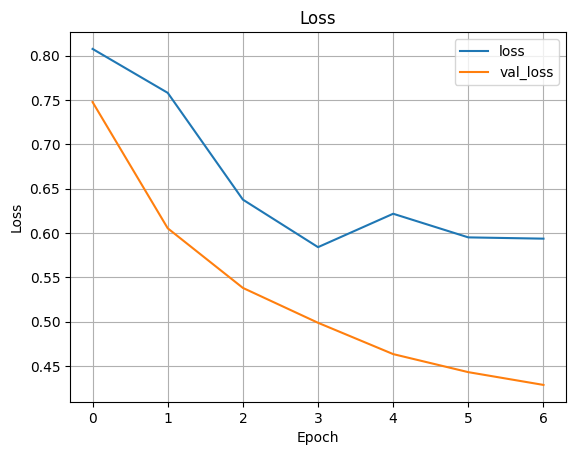

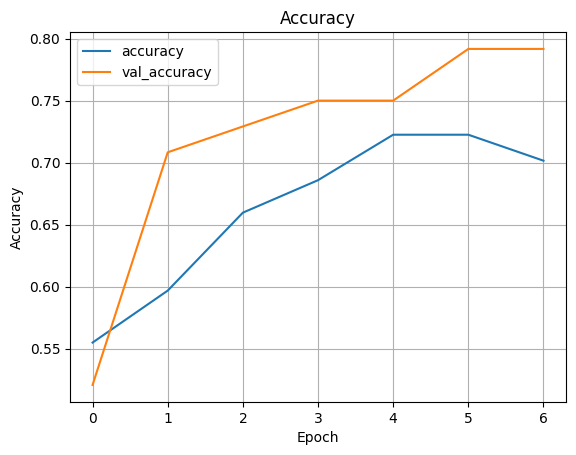

In [44]:
# Plot training history (loss & accuracy)

# Make plots render in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# If a prior cell set Agg, switch back to the inline backend
try:
    plt.switch_backend("module://matplotlib_inline.backend_inline")
except Exception:
    pass

import pandas as pd

# Plot losses
history_df = pd.DataFrame(history.history)
ax = history_df[["loss", "val_loss"]].plot()
ax.set_title("Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True)
plt.show()

# Plot accuracies
ax = history_df[["accuracy", "val_accuracy"]].plot()
ax.set_title("Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.grid(True)
plt.show()
